In [24]:
# Import all necessary libraries

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from facenet_pytorch import MTCNN
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import ray
from ray import train, tune
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler
from torchinfo import summary
from functools import partial
import os
import pandas as pd

In [5]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

# Tried with more transforms, but having too many seemed to negatively
# affect model performance. As long as there is the normalization + resize transforms,
# all the the other transformations didn't seem to postively affect the model much.
transforms_train = transforms.Compose([
    transforms.Pad(25, padding_mode='symmetric'),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(10),
    transforms.ColorJitter([1,1]),
    transforms.Resize((224, 224)),
    transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]), # ToTensor()
    transforms.Normalize(mean, std),  
])

transforms_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]), # ToTensor()
    transforms.Normalize(mean, std)
])
train_data_dir = './CASIA_dataset/training set/'
validation_data_dir = './CASIA_dataset/testing set/'
test_data_dir = './REPLAY_ATTACK/test/'

batch_size = 16

# Create ImageFolder datasets and data loaders
train_dataset = datasets.ImageFolder(train_data_dir, transform=transforms_train)
validation_dataset = datasets.ImageFolder(validation_data_dir, transform=transforms_val_test)
test_dataset = datasets.ImageFolder(test_data_dir, transform=transforms_val_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


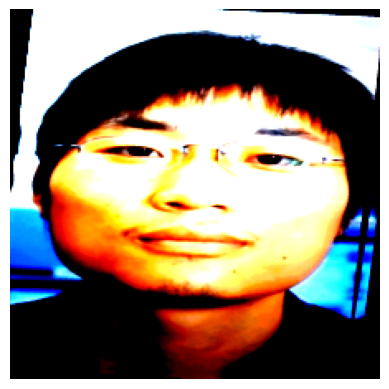

In [6]:
features, labels = next(iter(train_loader))

img = features[0].squeeze()
img = img.swapaxes(0,1).swapaxes(1,2)
label = labels[0]
plt.axis("off")
plt.imshow(img)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


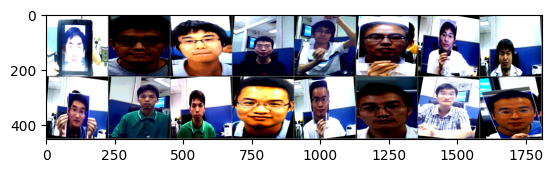

In [7]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show()

images, labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(images))

In [8]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 56 * 56, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CNNModel(num_classes=len(train_dataset.classes))

In [9]:
class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeepCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 1024, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(1024, 2048, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # flattens
        x = self.classifier(x)
        return x

#  model
deep_model = DeepCNN(num_classes=len(train_dataset.classes))

summary(deep_model, data_input=(16,3,224,224))
print(deep_model.features(images).shape)

torch.Size([16, 2048, 7, 7])


In [10]:
class BinaryCNN(nn.Module):
    def __init__(self, num_classes):
        super(BinaryCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.25)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 28 * 28, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # flattens
        x = self.classifier(x)
        return x

#  model
binary_model = BinaryCNN(num_classes=len(train_dataset.classes))

summary(binary_model, data_input=(16,3,224,224))
print(binary_model.features(images).shape)

torch.Size([16, 128, 28, 28])


In [11]:
class AlexNet_model(nn.Module):
    def __init__(self, num_classes):
        super(AlexNet_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, 5, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2), 
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256 * 5 * 5), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # flattens
        x = self.classifier(x)
        return x
    
alexnet_model = AlexNet_model(num_classes=len(train_dataset.classes))

In [12]:
data_dir = os.path.abspath("./")
def load_data(train_data_dir=f'{data_dir}/CASIA_dataset/training set/', validation_data_dir=f'{data_dir}/CASIA_dataset/testing set/', test_data_dir=f'{data_dir}/REPLAY_ATTACK/test/', batch_size=16):
    transforms_train = transforms.Compose([
        transforms.Pad(25, padding_mode='symmetric'),
        transforms.RandomHorizontalFlip(), 
        transforms.RandomRotation(10),
        transforms.ColorJitter([1,1]),
        transforms.Resize((224, 224)),
        transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]), # ToTensor()
        transforms.Normalize(mean, std),  
    ])

    transforms_val_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Compose([transforms.ToImage(), transforms.ToDtype(torch.float32, scale=True)]), # ToTensor()
        transforms.Normalize(mean, std)
    ])

    # Create ImageFolder datasets and data loaders
    train_dataset = datasets.ImageFolder(train_data_dir, transform=transforms_train)
    validation_dataset = datasets.ImageFolder(validation_data_dir, transform=transforms_val_test)
    test_dataset = datasets.ImageFolder(test_data_dir, transform=transforms_val_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, validation_loader, test_loader

In [15]:
def train_cnn_with_tuning(config, model_type, num_epochs=10):
    model = model_type(num_classes=len(train_dataset.classes))

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=0.9)

    train_loader, validation_loader, test_loader = load_data()

    # Lists to store training and validation loss
    train_losses = []
    val_losses = []

    # Lists to store training and validation accuracy
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Calculate training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        val_scores, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Store validation scores and labels for EER calculation
                val_scores.extend(outputs[:, 1].cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate validation loss and accuracy
        val_loss = val_loss / len(validation_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print and plot training and validation results
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        # Calculate Equal Error Rate (EER) on the validation set
        fpr, tpr, thresholds = roc_curve(val_labels, val_scores, pos_label=1)
        eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
        eer = 1 - tpr[np.argmin(np.abs(tpr - (1 - fpr)))]
        print(f'Validation EER: {eer:.4f}, EER Threshold: {eer_threshold:.4f}')

        # Testing set evaluation
        test_scores, test_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                test_scores.extend(outputs[:, 1].cpu().numpy())
                test_labels.extend(labels.cpu().numpy())

        # Calculate AUC on the testing set
        fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, test_scores, pos_label=1)
        auc_test = auc(fpr_test, tpr_test)
        print(f'Testing AUC: {auc_test:.4f}')

        # Calculate Half Total Error Rate (HTER) on the testing set using the EER threshold
        test_scores = np.array(test_scores)
        test_labels = np.array(test_labels)

        false_accepts = np.sum((test_scores >= eer_threshold) & (test_labels == 0))
        false_rejects = np.sum((test_scores < eer_threshold) & (test_labels == 1))

        hter = 0.5 * (false_accepts / np.sum(test_labels == 0) + false_rejects / np.sum(test_labels == 1))
        print(f'Testing HTER: {hter:.4f}')

        train.report(
            {"loss": val_loss, "accuracy": val_accuracy, "EER": eer, "AUC": auc_test, "HTER": hter}
        )
    print("Finished Training")

def train_with_tuning(model, num_samples=10, max_num_epochs=10, gpus_per_trial=1):
    ray.shutdown()
    ray.init(num_cpus=2, num_gpus=gpus_per_trial)

    config = {
    "lr": tune.loguniform(1e-4, 1e-1)
    }
    scheduler = ASHAScheduler(
        # Minimizing for loss, not HTER
        metric="HTER",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2,
        )
    result = tune.run(
        partial(train_cnn_with_tuning, model_type=model, num_epochs=max_num_epochs),
        resources_per_trial={"cpu": 2, "gpu": gpus_per_trial},
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        )
    
    
    best_trial = result.get_best_trial("HTER", "min", "last")
    print(f"Best trial config: {best_trial.config}")
    print(f"Best trial final validation loss: {best_trial.last_result['loss']}")
    print(f"Best trial final validation accuracy: {best_trial.last_result['accuracy']}")
    print(f"Best trial config EER: {best_trial.last_result['EER']}")
    print(f"Best trial config AUC: {best_trial.last_result['AUC']}")
    print(f"Best trial config HTER: {best_trial.last_result['HTER']}")

    return best_trial.config, best_trial.last_result['loss'], best_trial.last_result['accuracy'], best_trial.last_result['EER'], best_trial.last_result['AUC'], best_trial.last_result['HTER']

In [16]:
tuned_config, tuned_loss, tuned_accuracy, tuned_eer, tuned_auc, tuned_hter = train_with_tuning(DeepCNN)

2023-10-29 16:14:42,336	INFO worker.py:1642 -- Started a local Ray instance.
2023-10-29 16:14:42,751	INFO tune.py:645 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(func pid=4611) Epoch 1/10, Training Loss: 0.6873, Training Accuracy: 68.75%
(func pid=4611) Validation Loss: 0.6797, Validation Accuracy: 75.00%
(func pid=4611) Validation EER: 0.5333, EER Threshold: -0.0407


Trial name,AUC,EER,HTER,accuracy,loss
train_cnn_with_tuning_8145e_00000,0.778469,0.477778,0.3525,75,0.583696
train_cnn_with_tuning_8145e_00001,0.750797,0.466667,0.39625,75,0.637764
train_cnn_with_tuning_8145e_00002,0.54425,0.355556,0.49875,75.2778,0.548925
train_cnn_with_tuning_8145e_00003,0.591969,0.366667,0.42125,75,0.582187
train_cnn_with_tuning_8145e_00004,0.47875,0.333333,0.47,75,0.614751
train_cnn_with_tuning_8145e_00005,0.71625,0.455556,0.37875,75,0.653881
train_cnn_with_tuning_8145e_00006,0.6295,0.466667,0.39,75,0.575691
train_cnn_with_tuning_8145e_00007,0.792031,0.455556,0.2825,75,0.573109
train_cnn_with_tuning_8145e_00008,0.722906,0.577778,0.38,75,0.600206
train_cnn_with_tuning_8145e_00009,0.757844,0.477778,0.38125,75,0.586522


(func pid=4611) Testing AUC: 0.8365
(func pid=4611) Testing HTER: 0.2525
(func pid=4611) Epoch 2/10, Training Loss: 0.6660, Training Accuracy: 75.00%
(func pid=4611) Validation Loss: 0.6621, Validation Accuracy: 75.00%
(func pid=4611) Validation EER: 0.5111, EER Threshold: -0.0840
(func pid=4611) Testing AUC: 0.7775
(func pid=4611) Testing HTER: 0.3588
(func pid=4611) Epoch 3/10, Training Loss: 0.6462, Training Accuracy: 75.00%
(func pid=4611) Validation Loss: 0.6441, Validation Accuracy: 75.00%
(func pid=4611) Validation EER: 0.5000, EER Threshold: -0.1347
(func pid=4611) Testing AUC: 0.7569
(func pid=4611) Testing HTER: 0.3837
(func pid=4611) Epoch 4/10, Training Loss: 0.6263, Training Accuracy: 75.00%
(func pid=4611) Validation Loss: 0.6286, Validation Accuracy: 75.00%
(func pid=4611) Validation EER: 0.5000, EER Threshold: -0.1848
(func pid=4611) Testing AUC: 0.7511
(func pid=4611) Testing HTER: 0.3850
(func pid=4611) Epoch 5/10, Training Loss: 0.6090, Training Accuracy: 75.00%
(fun

2023-10-29 16:30:06,787	INFO tune.py:1143 -- Total run time: 924.04 seconds (924.01 seconds for the tuning loop).


Best trial config: {'lr': 0.00043802623146451926}
Best trial final validation loss: 0.5731091615946396
Best trial final validation accuracy: 75.0
Best trial config EER: 0.4555555555555556
Best trial config AUC: 0.79203125
Best trial config HTER: 0.2825


In [17]:
def train_cnn(model, lr=0.001, batch_size=16):

    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr) # switched to SGD instead of ADAM since it appears to be better for image classification 
    
    # Training loop
    num_epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cuda")
    model.to(device)

    # Lists to store training and validation loss
    train_losses = []
    val_losses = []

    # Lists to store training and validation accuracy
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        # Calculate training loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        val_scores, val_labels = [], []
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

                # Store validation scores and labels for EER calculation
                val_scores.extend(outputs[:, 1].cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        # Calculate validation loss and accuracy
        val_loss = val_loss / len(validation_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        # Print and plot training and validation results
        print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


    # Calculate Equal Error Rate (EER) on the validation set
    fpr, tpr, thresholds = roc_curve(val_labels, val_scores, pos_label=1)
    eer_threshold = thresholds[np.argmin(np.abs(tpr - (1 - fpr)))]
    eer = 1 - tpr[np.argmin(np.abs(tpr - (1 - fpr)))]
    print(f'Validation EER: {eer:.4f}, EER Threshold: {eer_threshold:.4f}')

    # Testing set evaluation
    test_scores, test_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_scores.extend(outputs[:, 1].cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # Calculate AUC on the testing set
    fpr_test, tpr_test, thresholds_test = roc_curve(test_labels, test_scores, pos_label=1)
    auc_test = auc(fpr_test, tpr_test)
    print(f'Testing AUC: {auc_test:.4f}')

    # Calculate Half Total Error Rate (HTER) on the testing set using the EER threshold
    test_scores = np.array(test_scores)
    test_labels = np.array(test_labels)

    false_accepts = np.sum((test_scores >= eer_threshold) & (test_labels == 0))
    false_rejects = np.sum((test_scores < eer_threshold) & (test_labels == 1))

    hter = 0.5 * (false_accepts / np.sum(test_labels == 0) + false_rejects / np.sum(test_labels == 1))
    print(f'Testing HTER: {hter:.4f}')

    return train_losses, val_losses, train_accuracies, val_accuracies, train_loss, val_loss, train_accuracy, val_accuracy, eer, auc_test, hter

In [18]:
tls, vls, tas, vas, tl, vl, ta, va, ee, au, ht = train_cnn(model)

Epoch 1/10, Training Loss: 0.5793, Training Accuracy: 71.25%
Validation Loss: 0.5775, Validation Accuracy: 75.00%
Epoch 2/10, Training Loss: 0.5496, Training Accuracy: 75.00%
Validation Loss: 0.5611, Validation Accuracy: 75.00%
Epoch 3/10, Training Loss: 0.5220, Training Accuracy: 76.25%
Validation Loss: 0.5505, Validation Accuracy: 75.00%
Epoch 4/10, Training Loss: 0.5300, Training Accuracy: 75.00%
Validation Loss: 0.5535, Validation Accuracy: 75.00%
Epoch 5/10, Training Loss: 0.4963, Training Accuracy: 75.00%
Validation Loss: 0.5340, Validation Accuracy: 75.28%
Epoch 6/10, Training Loss: 0.5026, Training Accuracy: 75.83%
Validation Loss: 0.5206, Validation Accuracy: 75.28%
Epoch 7/10, Training Loss: 0.4881, Training Accuracy: 75.83%
Validation Loss: 0.5225, Validation Accuracy: 75.28%
Epoch 8/10, Training Loss: 0.4595, Training Accuracy: 76.67%
Validation Loss: 0.5382, Validation Accuracy: 75.00%
Epoch 9/10, Training Loss: 0.4635, Training Accuracy: 77.08%
Validation Loss: 0.5044, Va

In [19]:
train_losses, val_losses, train_accuracies, val_accuracies, train_loss, val_loss, train_accuracy, val_accuracy, eer, auc_test, hter = train_cnn(deep_model)

Epoch 1/10, Training Loss: 0.6859, Training Accuracy: 67.50%
Validation Loss: 0.6777, Validation Accuracy: 75.00%
Epoch 2/10, Training Loss: 0.6660, Training Accuracy: 75.00%
Validation Loss: 0.6623, Validation Accuracy: 75.00%
Epoch 3/10, Training Loss: 0.6493, Training Accuracy: 75.00%
Validation Loss: 0.6487, Validation Accuracy: 75.00%
Epoch 4/10, Training Loss: 0.6339, Training Accuracy: 75.00%
Validation Loss: 0.6364, Validation Accuracy: 75.00%
Epoch 5/10, Training Loss: 0.6209, Training Accuracy: 75.00%
Validation Loss: 0.6255, Validation Accuracy: 75.00%
Epoch 6/10, Training Loss: 0.6084, Training Accuracy: 75.00%
Validation Loss: 0.6157, Validation Accuracy: 75.00%
Epoch 7/10, Training Loss: 0.5966, Training Accuracy: 75.00%
Validation Loss: 0.6070, Validation Accuracy: 75.00%
Epoch 8/10, Training Loss: 0.5898, Training Accuracy: 75.00%
Validation Loss: 0.5999, Validation Accuracy: 75.00%
Epoch 9/10, Training Loss: 0.5811, Training Accuracy: 75.00%
Validation Loss: 0.5939, Va

In [23]:
# HTER and AUC are results are better than original

In [20]:
btr_losses, bval_losses, btr_accs, bval_accs, btr_loss, bval_loss, btr_acc, bval_acc, beer, bauc, bhter = train_cnn(binary_model)

Epoch 1/10, Training Loss: 0.6835, Training Accuracy: 55.83%
Validation Loss: 0.6793, Validation Accuracy: 74.72%
Epoch 2/10, Training Loss: 0.6213, Training Accuracy: 75.42%
Validation Loss: 0.6523, Validation Accuracy: 75.00%
Epoch 3/10, Training Loss: 0.5804, Training Accuracy: 75.00%
Validation Loss: 0.6337, Validation Accuracy: 75.00%
Epoch 4/10, Training Loss: 0.5861, Training Accuracy: 75.00%
Validation Loss: 0.6267, Validation Accuracy: 75.00%
Epoch 5/10, Training Loss: 0.5646, Training Accuracy: 75.00%
Validation Loss: 0.6205, Validation Accuracy: 75.00%
Epoch 6/10, Training Loss: 0.5916, Training Accuracy: 75.00%
Validation Loss: 0.6218, Validation Accuracy: 75.00%
Epoch 7/10, Training Loss: 0.5739, Training Accuracy: 75.00%
Validation Loss: 0.6199, Validation Accuracy: 75.00%
Epoch 8/10, Training Loss: 0.5715, Training Accuracy: 75.00%
Validation Loss: 0.6189, Validation Accuracy: 75.00%
Epoch 9/10, Training Loss: 0.5768, Training Accuracy: 75.00%
Validation Loss: 0.6165, Va

In [21]:
# HTER and AUC are results are better

In [22]:
alex_train_losses, alex_val_losses, alex_train_accuracies, alex_val_accuracies, alex_train_loss, alex_val_loss, alex_train_accuracy, alex_val_accuracy, alex_eer, alex_auc_test, alex_hter = train_cnn(alexnet_model)

Epoch 1/10, Training Loss: 0.6906, Training Accuracy: 73.75%
Validation Loss: 0.6902, Validation Accuracy: 75.00%
Epoch 2/10, Training Loss: 0.6884, Training Accuracy: 75.00%
Validation Loss: 0.6877, Validation Accuracy: 75.00%
Epoch 3/10, Training Loss: 0.6854, Training Accuracy: 75.00%
Validation Loss: 0.6853, Validation Accuracy: 75.00%
Epoch 4/10, Training Loss: 0.6829, Training Accuracy: 75.00%
Validation Loss: 0.6829, Validation Accuracy: 75.00%
Epoch 5/10, Training Loss: 0.6806, Training Accuracy: 75.00%
Validation Loss: 0.6806, Validation Accuracy: 75.00%
Epoch 6/10, Training Loss: 0.6778, Training Accuracy: 75.00%
Validation Loss: 0.6783, Validation Accuracy: 75.00%
Epoch 7/10, Training Loss: 0.6756, Training Accuracy: 75.00%
Validation Loss: 0.6761, Validation Accuracy: 75.00%
Epoch 8/10, Training Loss: 0.6733, Training Accuracy: 75.00%
Validation Loss: 0.6739, Validation Accuracy: 75.00%
Epoch 9/10, Training Loss: 0.6709, Training Accuracy: 75.00%
Validation Loss: 0.6718, Va

In [15]:
# Using previous tuned (DeepCNN) results, since rerunning takes too much time

tuned_config = {'lr': 0.00043802623146451926}
tuned_loss = 0.5731091615946396
tuned_accuracy = 75.0
tuned_EER = 0.4555555555555556
tuned_AUC= 0.79203125
tuned_HTER= 0.2825

In [27]:
methods = ["Original CNN","Deep CNN 1", "Deep CNN 2", "Alexnet with CrossEntropyLoss","Deep CNN 1 with tuned learning rate"]
values = [ht, hter, bhter, alex_hter, tuned_hter]
df = pd.DataFrame({"Methods": methods, "Train: CASIA, Test: Replay-Attack (HTER)": values}).set_index("Methods")
df

,"Train: CASIA, Test: Replay-Attack (HTER)"
Methods,
Original CNN,0.57875
Deep CNN 1,0.31500
Deep CNN 2,0.38375
Alexnet with CrossEntropyLoss,0.53125
Deep CNN 1 with tuned learning rate,0.28250
